# Learn Local

I tried to learn the two category dataset, where the sets are either coming from distributions on interlinked tori, or two tori surfaces with one contained in the other. One glaring issue is that the distributions are not topologically linked, i.e. continuous functions will not be able to separate them. Neural networks with ReLU activation is one such example.

I tried to use discontinuous activation functions to overcome this issue, but to no avail. Perhaps it was a problem with implementation, but in my trial the learning rate did not improve.

Maybe the issue is that we're too ambitious in trying to come up with a single function that separates the two sets. Global topology of the two sets might be intricately connected. However locally the two sets can be separated, even by support vectors (SVM) if you zoom fine enough.

My proposal is to separate the whole dataset into particular clusters. Perhaps by k-means clustering, or better yet into a mixture of Gaussians. From the partition of unity with certain bump functions focusing our attention on a certain point of the data-set, we can train different neural networks classifying the two sets of points in those sets. Here the assumption is that you need less representational capacity to distinguish between two sets at the local scale. Then you can combine the various local separators using a weighted sum, weighted according to which gaussian a data point belongs to. I then call it a day, hopefully with better test accuracy and not too bad of a computational loss in training $k$-many neural networks.

In [1]:
##First we create some data.
import numpy as np
import DataMaker as dm

R = 10
r1 = 3
r2 = 1
N1 = 30000
N2 = 30000

x, y = dm.dataCreatorSheath(R, r1, r2,N1,N2)

#shuffle data
idx = np.random.permutation(len(x))
x,y = x[idx], y[idx]

dm.dataVisualizer(x,y)

<Figure size 640x480 with 1 Axes>

In [2]:
# partition of unity using mixture of Gaussian
from sklearn import mixture
import torch
import torch.tensor as tt
import torch.nn as nn
import torch.nn.functional as F

class FullyConnected(nn.Module):
    def __init__(self, input_dim=3, width=3, depth=4, num_classes=2):
        super(FullyConnected, self).__init__()
        self.input_dim = input_dim
        self.width = width
        self.depth = depth
        self.num_classes = num_classes    
       
        layers = []
        layers.append(nn.Linear(self.input_dim, self.width))
        layers.append(nn.ReLU())
        for i in range(self.depth - 2):
            layers.append(nn.Linear(self.width, self.width))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(self.width, self.num_classes))
        # I added a softmax layer, recall that somehow it wasn't learning w/o this one.
        layers.append(nn.Softmax(dim = -1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = self.net(x)
        return x

    
import torch.optim as optim
learning_rate = 0.001

# create a stochastic gradient descent optimizer that uses Mean Square Error Loss

def train(network, trainloader, epoch_no = 2, learning_rate = 0.01, momentum = 0.9):
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
    criterion = nn.MSELoss()
    for epoch in range(epoch_no):  
        running_loss = 0.0
        for i, data in enumerate(trainloader,0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
    
    print('Finished Training')

    
number_of_components = 20

gmm = mixture.GaussianMixture(n_components=number_of_components, covariance_type='full').fit(x)

## Train the networks

Now I want to train each network, of which there will be number_of_components many, with the data points that are deemed to come from a certain gaussian component. This has the effect that each network is trained with a local set of data points, hopefully with reduced boundary complexity. Then a new data point will first be classified into a component, then predicted to be in the red set or the blue set according to the relevant feed forward network. The idea is that with the simplified boundary complexity, a much shallower and thinner network will suffice to classify is just as good.

In this particular case where the data sets are inseparable using continuous networks due to topological restraints, it may even be a much better solution.

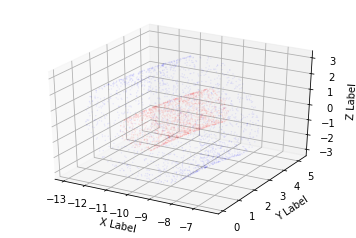

In [3]:
# We separate the labelled data as (a[i], b[i]) for i = 1,2,3,... number_of_components

a = list(range(number_of_components))
b = list(range(number_of_components))
for i in range(number_of_components):
    indices = gmm.predict(x)==i
    a[i] = x[indices]
    b[i] = y[indices]
    
dm.dataVisualizer(a[0], b[0])


In [4]:
trainsets = list(range(number_of_components))
trainloaders = list(range(number_of_components))

for i in range(number_of_components):
    trainsets[i] = list(zip(a[i], b[i]))
    trainloaders[i] = torch.utils.data.DataLoader(trainsets[i], batch_size=4, shuffle=True)


In [5]:
my_depth = 2
my_width = 3


networks = {}
for i in range(number_of_components):
    networks[f"net{i}"] = FullyConnected(width = my_width, depth = my_depth)

## Training the networks

Let us now train these networks.

net0


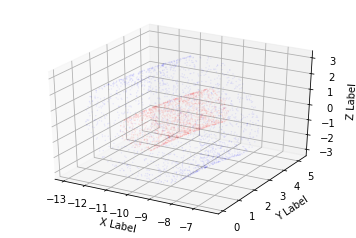

[1,   100] loss: 0.252
[1,   200] loss: 0.251
[1,   300] loss: 0.251
[1,   400] loss: 0.250
[1,   500] loss: 0.250
[1,   600] loss: 0.251
[1,   700] loss: 0.251
[1,   800] loss: 0.252
[2,   100] loss: 0.249
[2,   200] loss: 0.251
[2,   300] loss: 0.251
[2,   400] loss: 0.251
[2,   500] loss: 0.248
[2,   600] loss: 0.250
[2,   700] loss: 0.251
[2,   800] loss: 0.251
Finished Training
net1


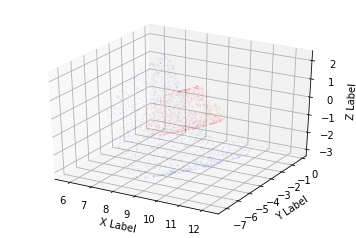

[1,   100] loss: 0.274
[1,   200] loss: 0.249
[1,   300] loss: 0.251
[1,   400] loss: 0.251
[1,   500] loss: 0.250
[1,   600] loss: 0.253
[2,   100] loss: 0.250
[2,   200] loss: 0.250
[2,   300] loss: 0.250
[2,   400] loss: 0.252
[2,   500] loss: 0.250
[2,   600] loss: 0.248
Finished Training
net2


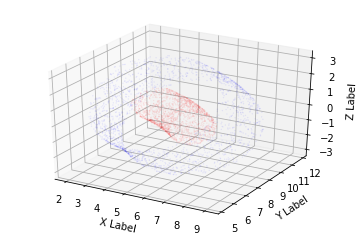

[1,   100] loss: 0.377
[1,   200] loss: 0.251
[1,   300] loss: 0.252
[1,   400] loss: 0.251
[1,   500] loss: 0.250
[1,   600] loss: 0.251
[1,   700] loss: 0.250
[1,   800] loss: 0.252
[1,   900] loss: 0.250
[2,   100] loss: 0.252
[2,   200] loss: 0.251
[2,   300] loss: 0.250
[2,   400] loss: 0.250
[2,   500] loss: 0.252
[2,   600] loss: 0.252
[2,   700] loss: 0.251
[2,   800] loss: 0.251
[2,   900] loss: 0.252
Finished Training
net3


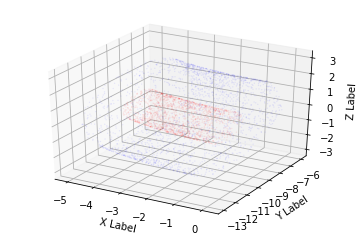

[1,   100] loss: 0.254
[1,   200] loss: 0.250
[1,   300] loss: 0.248
[1,   400] loss: 0.249
[1,   500] loss: 0.249
[1,   600] loss: 0.251
[1,   700] loss: 0.251
[1,   800] loss: 0.248
[1,   900] loss: 0.248
[2,   100] loss: 0.251
[2,   200] loss: 0.247
[2,   300] loss: 0.250
[2,   400] loss: 0.251
[2,   500] loss: 0.251
[2,   600] loss: 0.250
[2,   700] loss: 0.250
[2,   800] loss: 0.245
[2,   900] loss: 0.250
Finished Training
net4


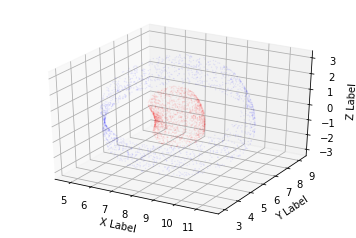

[1,   100] loss: 0.253
[1,   200] loss: 0.249
[1,   300] loss: 0.252
[1,   400] loss: 0.251
[1,   500] loss: 0.252
[1,   600] loss: 0.246
[1,   700] loss: 0.252
[1,   800] loss: 0.251
[2,   100] loss: 0.252
[2,   200] loss: 0.250
[2,   300] loss: 0.251
[2,   400] loss: 0.251
[2,   500] loss: 0.252
[2,   600] loss: 0.251
[2,   700] loss: 0.251
[2,   800] loss: 0.250
Finished Training
net5


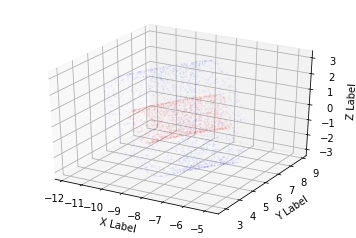

[1,   100] loss: 0.255
[1,   200] loss: 0.250
[1,   300] loss: 0.251
[1,   400] loss: 0.249
[1,   500] loss: 0.248
[1,   600] loss: 0.253
[1,   700] loss: 0.251
[1,   800] loss: 0.250
[2,   100] loss: 0.245
[2,   200] loss: 0.250
[2,   300] loss: 0.252
[2,   400] loss: 0.251
[2,   500] loss: 0.249
[2,   600] loss: 0.252
[2,   700] loss: 0.251
[2,   800] loss: 0.251
Finished Training
net6


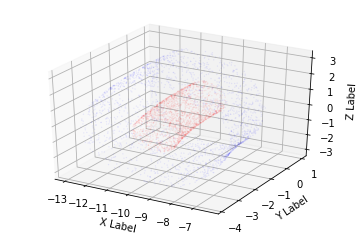

[1,   100] loss: 0.316
[1,   200] loss: 0.251
[1,   300] loss: 0.251
[1,   400] loss: 0.252
[1,   500] loss: 0.250
[1,   600] loss: 0.253
[1,   700] loss: 0.251
[1,   800] loss: 0.252
[1,   900] loss: 0.251
[2,   100] loss: 0.249
[2,   200] loss: 0.252
[2,   300] loss: 0.250
[2,   400] loss: 0.252
[2,   500] loss: 0.251
[2,   600] loss: 0.251
[2,   700] loss: 0.251
[2,   800] loss: 0.252
[2,   900] loss: 0.251
Finished Training
net7


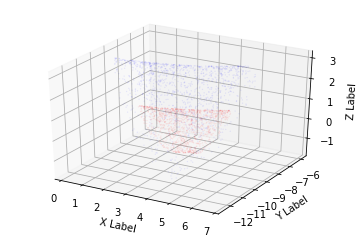

[1,   100] loss: 0.255
[1,   200] loss: 0.172
[1,   300] loss: 0.149
[1,   400] loss: 0.148
[1,   500] loss: 0.131
[1,   600] loss: 0.143
[2,   100] loss: 0.138
[2,   200] loss: 0.126
[2,   300] loss: 0.145
[2,   400] loss: 0.117
[2,   500] loss: 0.130
[2,   600] loss: 0.133
Finished Training
net8


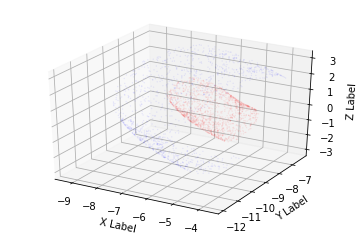

[1,   100] loss: 0.349
[1,   200] loss: 0.245
[1,   300] loss: 0.233
[1,   400] loss: 0.170
[1,   500] loss: 0.158
[1,   600] loss: 0.155
[2,   100] loss: 0.119
[2,   200] loss: 0.122
[2,   300] loss: 0.122
[2,   400] loss: 0.134
[2,   500] loss: 0.121
[2,   600] loss: 0.100
Finished Training
net9


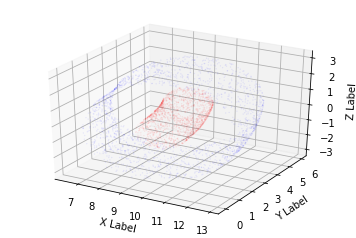

[1,   100] loss: 0.278
[1,   200] loss: 0.252
[1,   300] loss: 0.247
[1,   400] loss: 0.252
[1,   500] loss: 0.250
[1,   600] loss: 0.252
[1,   700] loss: 0.251
[1,   800] loss: 0.251
[1,   900] loss: 0.247
[2,   100] loss: 0.252
[2,   200] loss: 0.251
[2,   300] loss: 0.248
[2,   400] loss: 0.250
[2,   500] loss: 0.251
[2,   600] loss: 0.252
[2,   700] loss: 0.251
[2,   800] loss: 0.250
[2,   900] loss: 0.252
Finished Training
net10


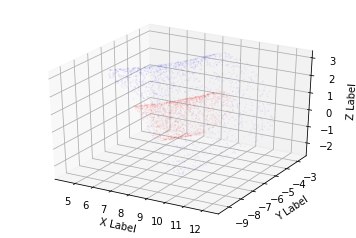

[1,   100] loss: 0.252
[1,   200] loss: 0.251
[1,   300] loss: 0.251
[1,   400] loss: 0.251
[1,   500] loss: 0.251
[1,   600] loss: 0.251
[1,   700] loss: 0.251
[2,   100] loss: 0.251
[2,   200] loss: 0.251
[2,   300] loss: 0.251
[2,   400] loss: 0.250
[2,   500] loss: 0.251
[2,   600] loss: 0.251
[2,   700] loss: 0.250
Finished Training
net11


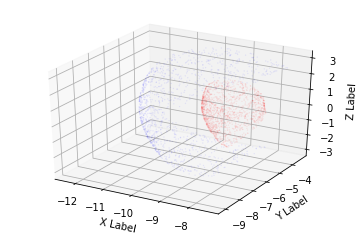

[1,   100] loss: 0.237
[1,   200] loss: 0.219
[1,   300] loss: 0.217
[1,   400] loss: 0.220
[1,   500] loss: 0.212
[1,   600] loss: 0.228
[2,   100] loss: 0.202
[2,   200] loss: 0.209
[2,   300] loss: 0.223
[2,   400] loss: 0.213
[2,   500] loss: 0.198
[2,   600] loss: 0.213
Finished Training
net12


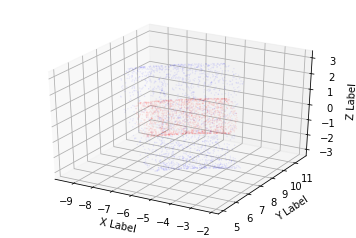

[1,   100] loss: 0.254
[1,   200] loss: 0.251
[1,   300] loss: 0.252
[1,   400] loss: 0.252
[1,   500] loss: 0.251
[1,   600] loss: 0.250
[1,   700] loss: 0.248
[1,   800] loss: 0.241
[1,   900] loss: 0.218
[2,   100] loss: 0.205
[2,   200] loss: 0.202
[2,   300] loss: 0.201
[2,   400] loss: 0.218
[2,   500] loss: 0.217
[2,   600] loss: 0.202
[2,   700] loss: 0.203
[2,   800] loss: 0.196
[2,   900] loss: 0.193
Finished Training
net13


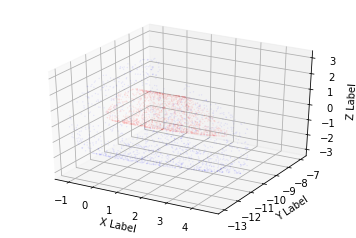

[1,   100] loss: 0.247
[1,   200] loss: 0.174
[1,   300] loss: 0.169
[1,   400] loss: 0.160
[1,   500] loss: 0.154
[1,   600] loss: 0.174
[1,   700] loss: 0.156
[2,   100] loss: 0.146
[2,   200] loss: 0.138
[2,   300] loss: 0.152
[2,   400] loss: 0.147
[2,   500] loss: 0.143
[2,   600] loss: 0.138
[2,   700] loss: 0.137
Finished Training
net14


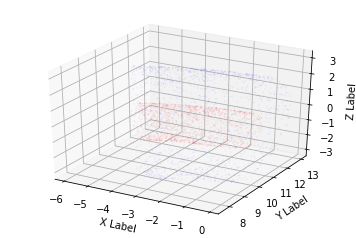

[1,   100] loss: 0.264
[1,   200] loss: 0.254
[1,   300] loss: 0.248
[1,   400] loss: 0.251
[1,   500] loss: 0.250
[1,   600] loss: 0.247
[1,   700] loss: 0.242
[2,   100] loss: 0.247
[2,   200] loss: 0.250
[2,   300] loss: 0.251
[2,   400] loss: 0.246
[2,   500] loss: 0.252
[2,   600] loss: 0.248
[2,   700] loss: 0.251
Finished Training
net15


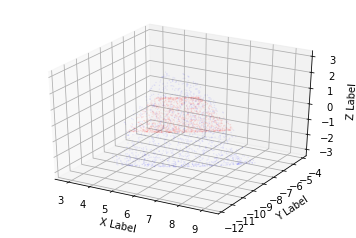

[1,   100] loss: 0.224
[1,   200] loss: 0.187
[1,   300] loss: 0.183
[1,   400] loss: 0.153
[1,   500] loss: 0.151
[1,   600] loss: 0.153
[2,   100] loss: 0.154
[2,   200] loss: 0.136
[2,   300] loss: 0.136
[2,   400] loss: 0.175
[2,   500] loss: 0.146
[2,   600] loss: 0.131
Finished Training
net16


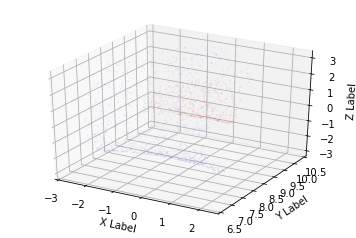

[1,   100] loss: 0.213
[1,   200] loss: 0.212
[1,   300] loss: 0.198
[1,   400] loss: 0.192
[2,   100] loss: 0.174
[2,   200] loss: 0.179
[2,   300] loss: 0.183
[2,   400] loss: 0.192
Finished Training
net17


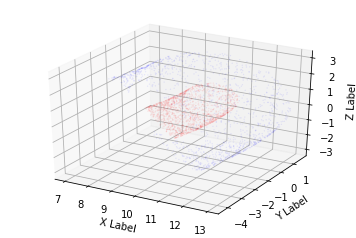

[1,   100] loss: 0.246
[1,   200] loss: 0.251
[1,   300] loss: 0.244
[1,   400] loss: 0.245
[1,   500] loss: 0.253
[1,   600] loss: 0.250
[1,   700] loss: 0.250
[2,   100] loss: 0.251
[2,   200] loss: 0.250
[2,   300] loss: 0.245
[2,   400] loss: 0.249
[2,   500] loss: 0.249
[2,   600] loss: 0.245
[2,   700] loss: 0.250
Finished Training
net18


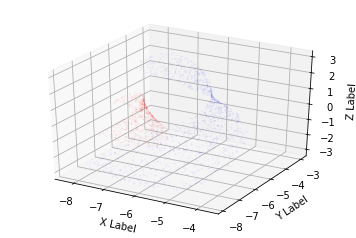

[1,   100] loss: 0.248
[1,   200] loss: 0.234
[1,   300] loss: 0.235
[1,   400] loss: 0.226
[2,   100] loss: 0.215
[2,   200] loss: 0.217
[2,   300] loss: 0.207
[2,   400] loss: 0.229
Finished Training
net19


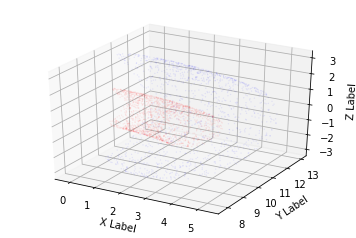

[1,   100] loss: 0.248
[1,   200] loss: 0.247
[1,   300] loss: 0.249
[1,   400] loss: 0.243
[1,   500] loss: 0.249
[1,   600] loss: 0.243
[2,   100] loss: 0.249
[2,   200] loss: 0.245
[2,   300] loss: 0.243
[2,   400] loss: 0.246
[2,   500] loss: 0.247
[2,   600] loss: 0.250
Finished Training


In [6]:
for i in range(number_of_components):
    print(f"net{i}")
    dm.dataVisualizer(a[i],b[i])
    train(networks[f"net{i}"], trainloaders[i], epoch_no = 2, learning_rate = 0.01)

In [7]:
x_test, y_test = dm.dataCreatorSheath(R,r1,r2, 3000,3000)

def percentIncorrect(networks, gaussian_mixture_model, x_test, y_test):
    #first predict which group your data point lies in
    predicted_components = gaussian_mixture_model.predict(x_test)
    guesses = list(map(lambda a,b : networks[f"net{a}"](b).argmax().item(), predicted_components, x_test))
    results = list(map(lambda a: a.argmax().item(), y_test))
    return ((np.array(guesses)  - np.array(results))**2).mean()
    
percentIncorrect(networks, gmm, x_test, y_test)

0.4103333333333333

## The interlinked tori set of points

Maybe there will be a better solution for this set of data points.

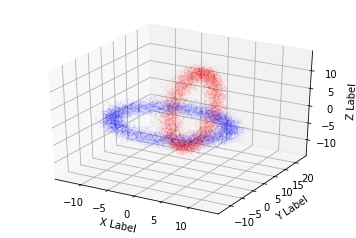

In [8]:
x2, y2 = dm.dataCreatorLinkedTori(10, 1, 10000,10000)

#shuffle data
idx = np.random.permutation(len(x2))
x2,y2 = x2[idx], y2[idx]

dm.dataVisualizer(x2,y2)

net0


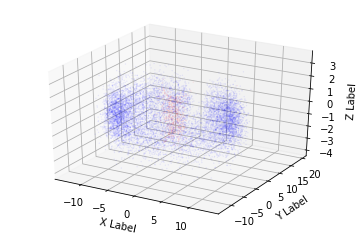

[1,   100] loss: 0.153
[1,   200] loss: 0.066
[1,   300] loss: 0.053
[1,   400] loss: 0.059
[1,   500] loss: 0.048
[1,   600] loss: 0.063
[1,   700] loss: 0.063
[1,   800] loss: 0.046
[1,   900] loss: 0.034
[1,  1000] loss: 0.052
[1,  1100] loss: 0.050
[1,  1200] loss: 0.052
[1,  1300] loss: 0.050
[1,  1400] loss: 0.054
[1,  1500] loss: 0.056
[1,  1600] loss: 0.045
[1,  1700] loss: 0.052
[1,  1800] loss: 0.041
[1,  1900] loss: 0.067
[1,  2000] loss: 0.085
[1,  2100] loss: 0.067
[1,  2200] loss: 0.060
[1,  2300] loss: 0.052
[1,  2400] loss: 0.056
[2,   100] loss: 0.062
[2,   200] loss: 0.042
[2,   300] loss: 0.057
[2,   400] loss: 0.080
[2,   500] loss: 0.050
[2,   600] loss: 0.039
[2,   700] loss: 0.054
[2,   800] loss: 0.053
[2,   900] loss: 0.057
[2,  1000] loss: 0.038
[2,  1100] loss: 0.051
[2,  1200] loss: 0.042
[2,  1300] loss: 0.054
[2,  1400] loss: 0.044
[2,  1500] loss: 0.039
[2,  1600] loss: 0.031
[2,  1700] loss: 0.035
[2,  1800] loss: 0.033
[2,  1900] loss: 0.018
[2,  2000] 

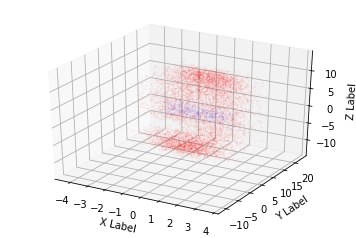

[1,   100] loss: 0.086
[1,   200] loss: 0.065
[1,   300] loss: 0.052
[1,   400] loss: 0.054
[1,   500] loss: 0.053
[1,   600] loss: 0.041
[1,   700] loss: 0.056
[1,   800] loss: 0.055
[1,   900] loss: 0.046
[1,  1000] loss: 0.031
[1,  1100] loss: 0.042
[1,  1200] loss: 0.030
[1,  1300] loss: 0.030
[1,  1400] loss: 0.045
[1,  1500] loss: 0.045
[1,  1600] loss: 0.028
[1,  1700] loss: 0.038
[1,  1800] loss: 0.032
[1,  1900] loss: 0.034
[1,  2000] loss: 0.032
[1,  2100] loss: 0.029
[1,  2200] loss: 0.041
[1,  2300] loss: 0.035
[1,  2400] loss: 0.044
[1,  2500] loss: 0.033
[2,   100] loss: 0.029
[2,   200] loss: 0.022
[2,   300] loss: 0.037
[2,   400] loss: 0.025
[2,   500] loss: 0.047
[2,   600] loss: 0.027
[2,   700] loss: 0.024
[2,   800] loss: 0.036
[2,   900] loss: 0.039
[2,  1000] loss: 0.037
[2,  1100] loss: 0.021
[2,  1200] loss: 0.025
[2,  1300] loss: 0.029
[2,  1400] loss: 0.027
[2,  1500] loss: 0.024
[2,  1600] loss: 0.024
[2,  1700] loss: 0.039
[2,  1800] loss: 0.050
[2,  1900] 

In [19]:
number_of_components2 = 2

gmm2 = mixture.GaussianMixture(n_components=number_of_components2, covariance_type='full').fit(x2)

a2 = list(range(number_of_components2))
b2 = list(range(number_of_components2))
for i in range(number_of_components2):
    indices = gmm2.predict(x2)==i
    a2[i] = x2[indices]
    b2[i] = y2[indices]
    
trainsets2 = list(range(number_of_components2))
trainloaders2 = list(range(number_of_components2))

for i in range(number_of_components2):
    trainsets2[i] = list(zip(a2[i], b2[i]))
    trainloaders2[i] = torch.utils.data.DataLoader(trainsets2[i], batch_size=4, shuffle=True)
    
    
networks2 = {}
for i in range(number_of_components2):
    networks2[f"net{i}"] = FullyConnected(width = 3, depth = 4)
    
for i in range(number_of_components2):
    print(f"net{i}")
    dm.dataVisualizer(a2[i],b2[i])
    train(networks2[f"net{i}"], trainloaders2[i], epoch_no = 5, learning_rate = 0.01)

In [20]:
x_test2, y_test2 = dm.dataCreatorLinkedTori(R,r1, 3000,3000)

percentIncorrect(networks2,gmm2, x_test2, y_test2)

0.0555

# Seeing what happens layer by layer.

Honestly I am surprised, that the error is not smaller. I would expect there to be better performance in the test error. Perhaps the number of components and the different number of neural networks might be a problem.

For this I want to see what happens in each layer to the data set. 

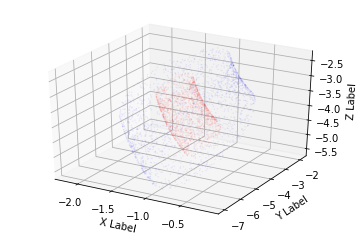

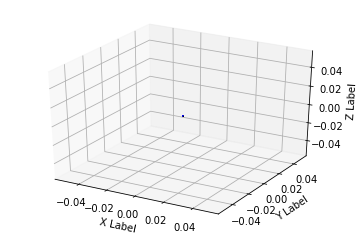

In [21]:
class NetworkVisualizer():
    def __init__(self, network):
        self.net = network
        self.rep = {}

    def hook_fn(self, module, inp, out):
        self.rep[module] = out

    #This is what the website had, assuming perhaps that you could have some nn.Sequential and 
    #maybe more nn.Sequential's nested inside etc. etc. 
    def get_values_from_layers(self, network):
        for name, layer in network._modules.items():
        #If it is a sequential, don't register a hook on it
        # but recursively register hook on all it's module children
            if isinstance(layer, nn.Sequential):
                self.get_values_from_layers(layer)
            else:
                # it's a non sequential. Register a hook
                layer.register_forward_hook(self.hook_fn)
            
    def visualizeLayers(self, xs, ys):
        net = self.net
        rep = self.rep
        self.get_values_from_layers(net)
        net(xs)
        for key in list(rep.keys())[:-2]:
            transformedpoints = rep[key].detach()
            dm.dataVisualizer(transformedpoints, ys)


nv = NetworkVisualizer(networks["net0"])
nv.visualizeLayers(a[0],b[0])

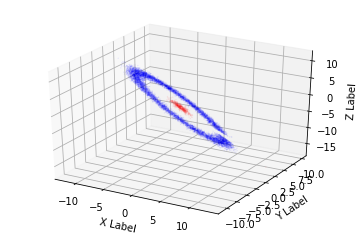

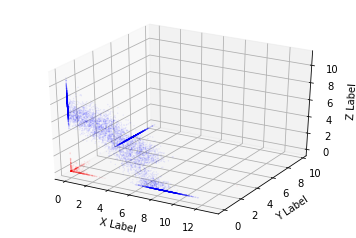

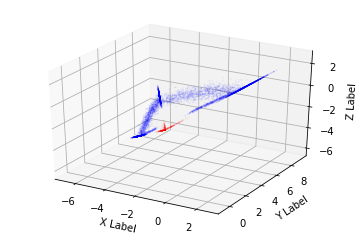

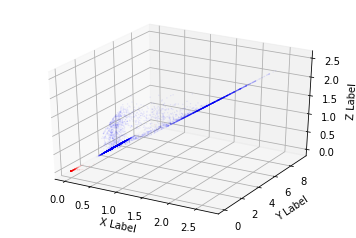

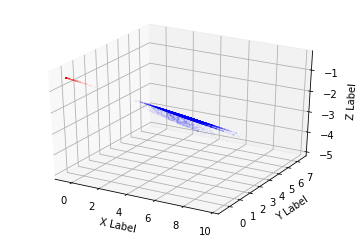

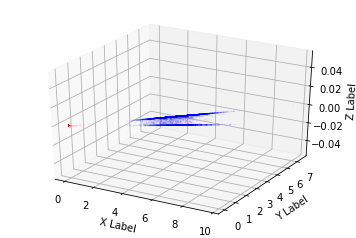

In [23]:
nv2i = NetworkVisualizer(networks2["net0"])
nv2i.visualizeLayers(a2[0],b2[0])

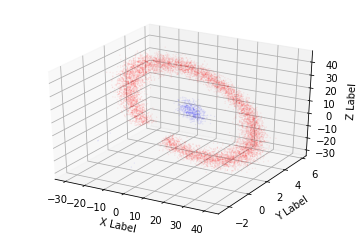

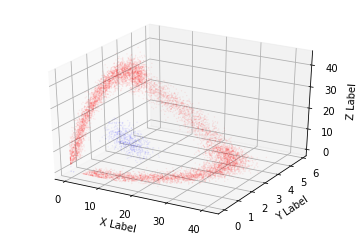

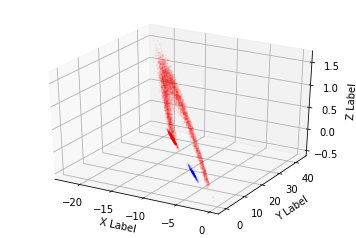

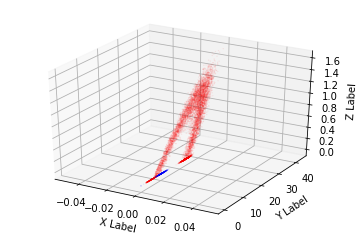

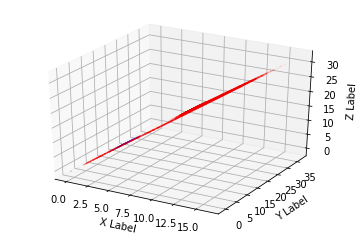

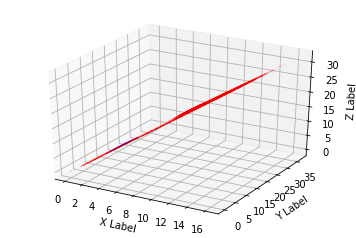

In [25]:
nv2ii = NetworkVisualizer(networks2["net1"])
nv2ii.visualizeLayers(a2[1],b2[1])

Wow! The second network, which has been trained to the dataset $a2[1], b2[1]$ couldn't perform shit. Not horrible, but given how simple the data set began, it is shameful. 

to Levent: 

It is surprising how a simple set such as this one cannot be learned by a standard feed forward network. I think it must be my network training. Somehow I am doing something wrong. Bunu da yapamayacaksa artık.

Ok I am not giving up on the idea that localization of the data set to a region and then training different networks for each locale is an idea that can possibly allow us to simplify the networks. Admittedly we will have more networks, but we may in the end have saved upon training time and maybe also calculation time (feed forward network'te bu pek sorun olmayabilir zaten, o yüzden burayı pek ciddiye alma).

It might be interesting to see which of these two opposing forces win in the tug of war as the dimensionality of the data flies off to infinity. 